In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

def getFeatures(image,n,m):

    features = np.empty((0,77))

    for u in range(n,m):

        #Cargamos la imagen
        img = cv2.imread(image+str(u)+".jpg",0)
        ret,thresh = cv2.threshold(img,127,255,0)

        #Determinamos unicamente sus contornos externos para la firma
        im, cnt, hcy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        x,y,w,h = cv2.boundingRect(cnt[0])
        img = img[y:y+h,x:x+w]

        ret,thresh = cv2.threshold(img,127,255,0)
        im, cnt, hcy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

        img2 = np.zeros(img.shape,np.uint8)
        cv2.drawContours(img2,cnt,0,255,0)
        #Determinamos los segmentos de frontera
        hull = []
        for i in range(len(cnt)):
            hull.append(cv2.convexHull(cnt[i]))

        img3 = np.zeros(img.shape,np.uint8)
        cv2.drawContours(img3,hull,0,255,0)
        
        img4 = np.zeros(img.shape,np.uint8)
        cv2.drawContours(img4,hull,0,255,cv2.FILLED)

        #Calculo de centroide del original
        M = cv2.moments(img)
        cX = int(M["m10"]/M["m00"])
        cY = int(M["m01"]/M["m00"])

        #Calculo de centroide del contornos
        MC = cv2.moments(img2)
        cXC = int(MC["m10"]/MC["m00"])
        cYC = int(MC["m01"]/MC["m00"])

        #Calculo de centroide del hull
        MH = cv2.moments(img3)
        cXH = int(MH["m10"]/MH["m00"])
        cYH = int(MH["m01"]/MH["m00"])
        
        #Calculo de centroide del contornos
        MHF = cv2.moments(img4)
        cXHF = int(MHF["m10"]/MHF["m00"])
        cYHF = int(MHF["m01"]/MHF["m00"])

        #Utilizamos centroide del Hull para la firma
        #Calculo de la firma
        signature = np.empty(shape=[0, 2])
        for j in range(img3.shape[0]):
            for i in range(img3.shape[1]):
                if(img3[j,i]==255):
                    #print(i,j)
                    signature = np.append(signature,[[math.atan2(-(j-cYH),(i-cXH)),math.sqrt((i-cXH)**2+(j-cYH)**2)]],axis=0)

        #Ordenamiento y Normalizacion de la firma
        signature = signature[np.argsort(signature[:,0])]
        signaturen = np.copy(signature)        
        
        signature[:,1] = signature[:,1]/max(signature[:,1])

        #Calculo de Histograma de la firma para momentos estadisticos
        bins = 100
        hist = np.histogram(signature,bins,[0,1])
        nElements = np.sum(hist[0])
        maxHist = max(hist[0])

        #Calculo probabilidades del histograma
        prob = np.empty(shape=[0,10])
        for i in range(len(hist[0])):
            prob = np.append(prob,float(hist[0][i])/float(nElements))

        #Normalizacion del histograma
        nHist = np.empty(shape=[0,10])
        for i in range(len(hist[0])):
            nHist = np.append(nHist,float(hist[0][i])/float(maxHist))


        #Momentos Generales

        m1=float(0)
        for i in range(len(prob)):    
            m1 = m1 + float(nHist[i]**1)*float(prob[i])

        m2=float(0)
        for i in range(len(prob)):    
            m2 = m2 + float(nHist[i]**2)*float(prob[i])

        m3=float(0)
        for i in range(len(prob)):    
            m3 = m3 + float(nHist[i]**3)*float(prob[i])

        #Momentos Centrales
        miu1=float(0)
        for i in range(len(prob)):    
            miu1 = miu1 + float((nHist[i]-m1)**1)*float(prob[i])

        miu2=float(0)
        for i in range(len(prob)):    
            miu2 = miu2 + float((nHist[i]-m1)**2)*float(prob[i])

        miu3=float(0)
        for i in range(len(prob)):    
            miu3 = miu3 + float((nHist[i]-m1)**3)*float(prob[i])

        #Momentos Centrales Absolutos
        amiu1=float(0)
        for i in range(len(prob)):    
            amiu1 = amiu1 + float(abs((nHist[i]-m1))**1)*float(prob[i])

        amiu2=float(0)
        for i in range(len(prob)):    
            amiu2 = amiu2 + float(abs((nHist[i]-m1))**2)*float(prob[i])

        amiu3=float(0)
        for i in range(len(prob)):    
            amiu3 = amiu3 + float(abs((nHist[i]-m1))**3)*float(prob[i])


        #Perimetro externo y Perimetro Hull
        ar = cv2.contourArea(cnt[0])
        arH = cv2.contourArea(hull[0])

        rar = ar/arH

        #Area externa y Area Hull

        per = cv2.arcLength(cnt[0],True)
        perH = cv2.arcLength(hull[0], True)

        rper = perH/per

        #Compacidad

        comp = (per**2)/ar
        compH = (perH**2)/arH

        rcomp = compH/comp

        #Redondez

        red = (4*math.pi*ar)/(per**2)
        redH = (4*math.pi*arH)/(perH**2)
        rred = red/redH

        sigMean, sigDev = cv2.meanStdDev(signature)

        sigHistMean, sigHistDev = cv2.meanStdDev(nHist)

        #print("Momentos centralizados")
        m00 = M["m00"]
        m10 = M["m10"]
        m01 = M["m01"]
        m20 = M["m20"]
        m11 = M["m11"]
        m02 = M["m02"]
        m30 = M["m30"]
        m21 = M["m21"]
        m12 = M["m12"]
        m03 = M["m03"]
        mu11 = M["mu11"]
        mu20 = M["mu20"]
        mu02 = M["mu02"]
        mu30 = M["mu30"]
        mu03 = M["mu03"]
        mu21 = M["mu21"]
        mu12 = M["mu12"]
        #print("Momentos Centralizados Normalizados")
        nu11 = M["nu11"]
        nu20 = M["nu20"]
        nu02 = M["nu02"]
        nu30 = M["nu30"]
        nu03 = M["nu03"]
        nu21 = M["nu21"]
        nu12 = M["nu12"]
        #print("Momentos Invariantes de Hu")
        hu = cv2.HuMoments(M)
        l1 = hu[0]
        l2 = hu[1]
        l3 = hu[2]
        l4 = hu[3]
        l5 = hu[4]
        l6 = hu[5]
        l7 = hu[6]

        #print("Momentos centralizados Contorno")
        mC00 = MC["m00"]
        mC10 = MC["m10"]
        mC01 = MC["m01"]
        mC20 = MC["m20"]
        mC11 = MC["m11"]
        mC02 = MC["m02"]
        mC30 = MC["m30"]
        mC21 = MC["m21"]
        mC12 = MC["m12"]
        mC03 = MC["m03"]
        muC11 = MC["mu11"]
        muC20 = MC["mu20"]
        muC02 = MC["mu02"]
        muC30 = MC["mu30"]
        muC03 = MC["mu03"]
        muC21 = MC["mu21"]
        muC12 = MC["mu12"]
        #print("Momentos Centralizados Normalizados Contorno")
        nuC11 = MC["nu11"]
        nuC20 = MC["nu20"]
        nuC02 = MC["nu02"]
        nuC30 = MC["nu30"]
        nuC03 = MC["nu03"]
        nuC21 = MC["nu21"]
        nuC12 = MC["nu12"]
        #print("Momentos Invariantes de Hu Contorno")
        huC = cv2.HuMoments(MC)
        lC1 = huC[0]
        lC2 = huC[1]
        lC3 = huC[2]
        lC4 = huC[3]
        lC5 = huC[4]
        lC6 = huC[5]
        lC7 = huC[6]
        
        #print("Momentos centralizados Hull")
        mH00 = MH["m00"]
        mH10 = MH["m10"]
        mH01 = MH["m01"]
        mH20 = MH["m20"]
        mH11 = MH["m11"]
        mH02 = MH["m02"]
        mH30 = MH["m30"]
        mH21 = MH["m21"]
        mH12 = MH["m12"]
        mH03 = MH["m03"]
        muH11 = MH["mu11"]
        muH20 = MH["mu20"]
        muH02 = MH["mu02"]
        muH30 = MH["mu30"]
        muH03 = MH["mu03"]
        muH21 = MH["mu21"]
        muH12 = MH["mu12"]
        #print("Momentos Centralizados Normalizados")
        nuH11 = MH["nu11"]
        nuH20 = MH["nu20"]
        nuH02 = MH["nu02"]
        nuH30 = MH["nu30"]
        nuH03 = MH["nu03"]
        nuH21 = MH["nu21"]
        nuH12 = MH["nu12"]
        #print("Momentos Invariantes de Hu")
        huH = cv2.HuMoments(MH)
        lH1 = huH[0]
        lH2 = huH[1]
        lH3 = huH[2]
        lH4 = huH[3]
        lH5 = huH[4]
        lH6 = huH[5]
        lH7 = huH[6]
        
        #print("Momentos centralizados Hull Filled")
        mHF00 = MHF["m00"]
        mHF10 = MHF["m10"]
        mHF01 = MHF["m01"]
        mHF20 = MHF["m20"]
        mHF11 = MHF["m11"]
        mHF02 = MHF["m02"]
        mHF30 = MHF["m30"]
        mHF21 = MHF["m21"]
        mHF12 = MHF["m12"]
        mHF03 = MHF["m03"]
        muHF11 = MHF["mu11"]
        muHF20 = MHF["mu20"]
        muHF02 = MHF["mu02"]
        muHF30 = MHF["mu30"]
        muHF03 = MHF["mu03"]
        muHF21 = MHF["mu21"]
        muHF12 = MHF["mu12"]
        #print("Momentos Centralizados Normalizados")
        nuHF11 = MHF["nu11"]
        nuHF20 = MHF["nu20"]
        nuHF02 = MHF["nu02"]
        nuHF30 = MHF["nu30"]
        nuHF03 = MHF["nu03"]
        nuHF21 = MHF["nu21"]
        nuHF12 = MHF["nu12"]
        #print("Momentos Invariantes de Hu")
        huHF = cv2.HuMoments(MHF)
        lHF1 = huHF[0]
        lHF2 = huHF[1]
        lHF3 = huHF[2]
        lHF4 = huHF[3]
        lHF5 = huHF[4]
        lHF6 = huHF[5]
        lHF7 = huHF[6]

        #print("Relacion de momentos C")
        rmC00 = mH00/mC00
        rmC10 = mH10/mC10
        rmC01 = mH01/mC01
        rmC20 = mH20/mC20
        rmC11 = mH11/mC11
        rmC02 = mH02/mC02
        rmC30 = mH30/mC30
        rmC21 = mH21/mC21
        rmC12 = mH12/mC12
        rmC03 = mH03/mC03
        rmuC11 = muH11/muC11
        rmuC20 = muH20/muC20
        rmuC02 = muH02/muC02
        rmuC30 = muH30/muC30
        rmuC03 = muH03/muC03
        rmuC21 = muH21/muC21
        rmuC12 = muH12/muC12

        #print("Relacion de momentos Hull")

        rmF00 = m00/mHF00
        rmF10 = m10/mHF10
        rmF01 = m01/mHF01
        rmF20 = m20/mHF20
        rmF11 = m11/mHF11
        rmF02 = m02/mHF02
        rmF30 = m30/mHF30
        rmF21 = m21/mHF21
        rmF12 = m12/mHF12
        rmF03 = m03/mHF03
        rmuF11 = mu11/muHF11
        rmuF20 = mu20/muHF20
        rmuF02 = mu02/muHF02
        rmuF30 = mu30/muHF30
        rmuF03 = mu03/muHF03
        rmuF21 = mu21/muHF21
        rmuF12 = mu12/muHF12
        
        lenCnt = len(cnt)

        temp = np.array( [[m1,m2,m3,miu1,miu2,miu3,amiu1,amiu2,amiu3,#9
                           sigMean,sigDev, sigHistMean, sigHistDev, #4 ->13
                           rar,rper,comp,compH,rcomp,red,redH,rred, #8 ->21
                           #mC00,mC11,mC20,mC02,mC30,mC03,mC21,mC12,mC10,mC01, #10 ->31
                           #muC11,muC20,muC02,muC30,muC03,muC21,muC12,#7 ->38
                           nuC11,nuC20,nuC02,nuC30,nuC03,nuC21,nuC12, #7 ->28
                           #lC1,lC2,lC3,lC4,lC5,lC6,lC7, #7 ->35
                           #mH00,mH11,mH20,mH02,mH30,mH03,mH21,mH12,mH10,mH01,#10 ->62
                           #muH11,muH20,muH02,muH30,muH03,muH21,muH12, #7 ->69
                           nuH11,nuH20,nuH02,nuH30,nuH03,nuH21,nuH12, #7 ->42
                           #lH1,lH2,lH3,lH4,lH5,lH6,lH7, #7 ->49
                           #m00,m11,m20,m02,m30,m03,m21,m12,m10,m01, #10 ->93
                           #mu11,mu20,mu02,mu30,mu03,mu21,mu12, #7 ->100
                           nu11,nu20,nu02,nu30,nu03,nu21,nu12, #7 ->56
                           #l1,l2,l3,l4,l5,l6,l7,  #7 ->63
                           rmC00,rmC11,rmC20,rmC02,rmC30,rmC03,rmC21,rmC12,rmC10,rmC01, #10 ->73
                           rmuC11,rmuC20,rmuC02,rmuC30,rmuC03,rmuC21,rmuC12, #7 ->80
                           rmF00,rmF11,rmF20,rmF02,rmF30,rmF03,rmF21,rmF12,rmF10,rmF01, #10 ->90
                           rmuF11,rmuF20,rmuF02,rmuF30,rmuF03,rmuF21,rmuF12, #7 ->97 
                           lenCnt, # 1 -> 98
                           #lHF1,lHF2,lHF3,lHF4,lHF5,lHF6,lHF7
                           ]]) # 7 -> 105
        
        features = np.concatenate([features,temp])
        

    plt.figure(figsize=[15,15])
    plt.subplot(141), plt.imshow(img)
    plt.subplot(142), plt.imshow(img2)
    plt.subplot(143), plt.imshow(img3)
    plt.subplot(144), plt.imshow(img4)

    #plt.figure(figsize=[10,5])       
    #plt.subplot(131), plt.plot(signaturen[:,0],signaturen[:,1])
    plt.figure(figsize=[10,5])       
    plt.subplot(132), plt.plot(signature[:,0],signature[:,1])
    plt.ylim((0,1))


    newHist = np.delete(hist[1],0)
    plt.subplot(133), plt.plot(newHist,nHist)


    plt.show()


    #features = features[:,:21]

#cv2.imshow('img',img3)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
        
    return features
    


In [5]:
#PCA
def getPCAFeatures(image,n,m,retVar):
    features = getFeatures(image,n,m)

    mean = np.empty((0))
    #mean, eigenvectors = cv2.PCACompute(features, mean, retainedVariance = retVar)
    
    #mean, eigenvectors = cv2.PCACompute(features, mean)
    #eigenvectors = eigenvectors[:2,:]
    
    print("Vector Mean")
    print(len(mean))
    print(len(mean[0]))
    print("Vector Caracteristicas")
    print(len(features))
    print(len(features[0]))
    print("EigenVector "+str(retVar*100)+"%")
    print(len(eigenvectors))
    print(len(eigenvectors[0]))
    
    transformed = cv2.PCAProject(features,mean,eigenvectors)
    
    print("Vector de Caracteristicas PCA "+str(retVar*100)+"%")
    print(len(transformed))
    print(len(transformed[0]))

    #plt.figure(1)
    #plt.plot(transformed,'rx')
    #plt.show()
    return transformed



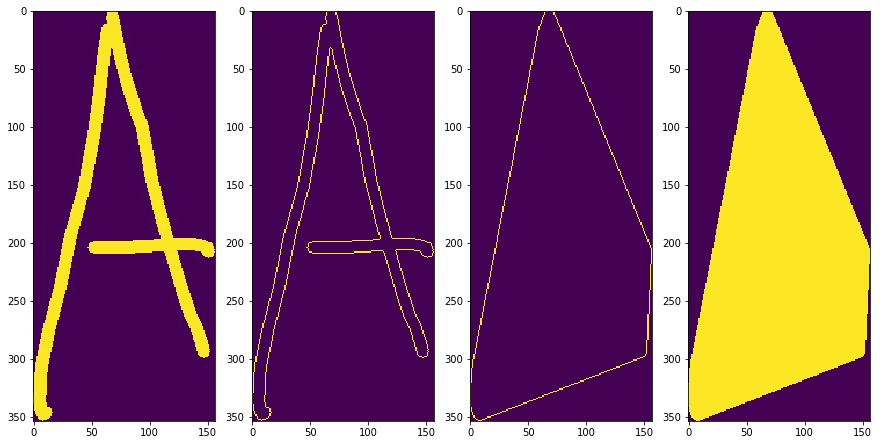

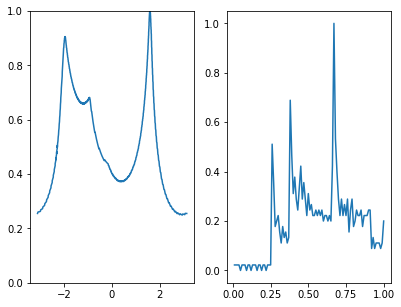

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 100%
30
77
Vector de Caracteristicas PCA 100%
30
30


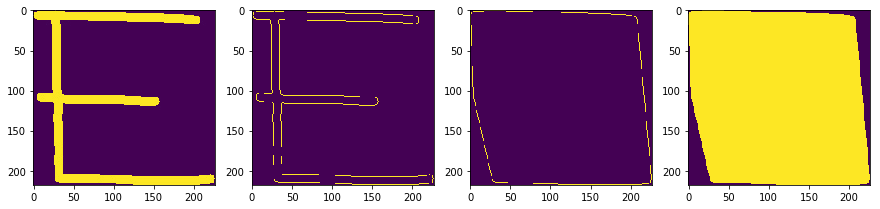

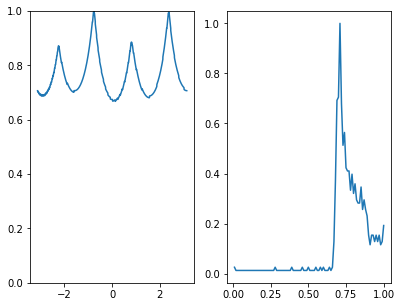

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 100%
30
77
Vector de Caracteristicas PCA 100%
30
30


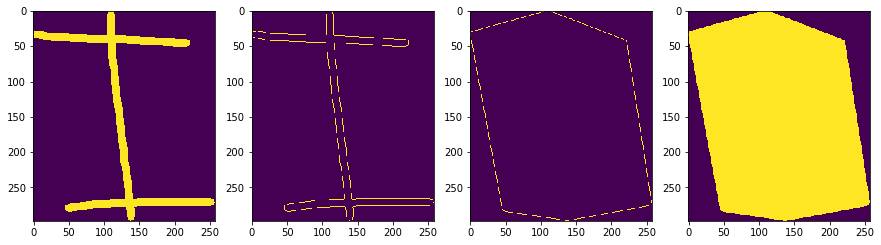

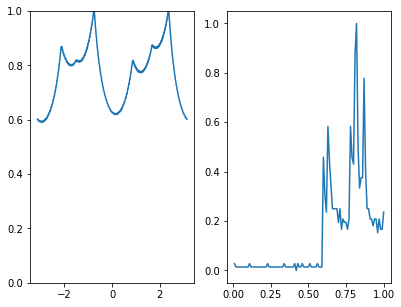

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 100%
30
77
Vector de Caracteristicas PCA 100%
30
30


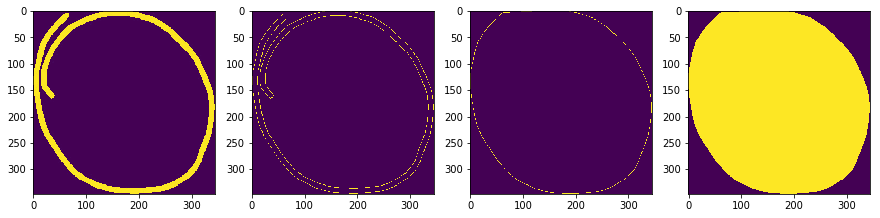

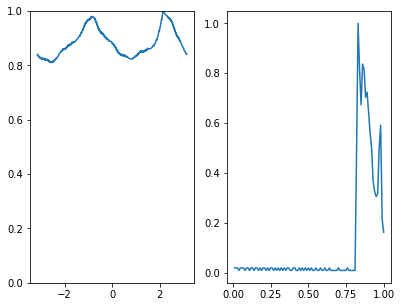

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 100%
30
77
Vector de Caracteristicas PCA 100%
30
30


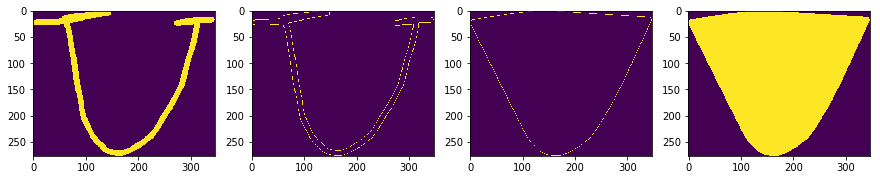

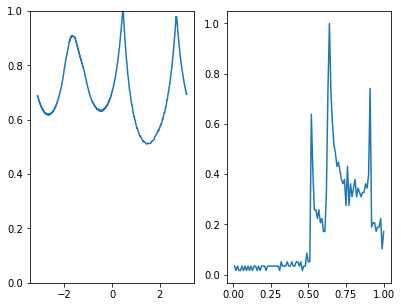

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 100%
30
77
Vector de Caracteristicas PCA 100%
30
30


In [8]:
# KMeans
retVar = 1
A = getPCAFeatures("A_mayuscula",1,31,retVar)
A = np.array(A, dtype=np.float32)
E = getPCAFeatures("E_mayuscula",1,31,retVar)
E = np.array(E, dtype=np.float32)
I = getPCAFeatures("I_mayuscula",1,31,retVar)
I = np.array(I, dtype=np.float32)
O = getPCAFeatures("O_mayuscula",1,31,retVar)
O = np.array(O, dtype=np.float32)
U = getPCAFeatures("U_mayuscula",1,31,retVar)
U = np.array(U, dtype=np.float32)

X = np.concatenate((A,E,I,O,U),axis=0)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret,label,center=cv2.kmeans(X,K,None,criteria,100,cv2.KMEANS_RANDOM_CENTERS)

# Now separate the data, Note the flatten()
a = X[label.ravel()==0]
e = X[label.ravel()==1]
i = X[label.ravel()==2]
o = X[label.ravel()==3]
u = X[label.ravel()==4]




C:\Users\hp\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


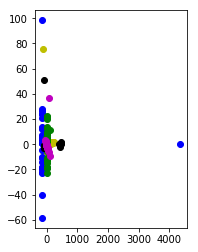

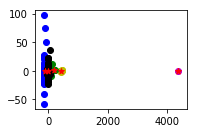

In [6]:
# Plot the data
plt.figure(1)
plt.subplot(121), plt.plot(A[:,0],A[:,1],'yo')
plt.subplot(121),plt.plot(E[:,0],E[:,1],'bo')
plt.subplot(121),plt.plot(I[:,0],I[:,1],'go')
plt.subplot(121),plt.plot(O[:,0],O[:,1],'ko')
plt.subplot(121),plt.plot(U[:,0],U[:,1],'mo')

#plt.subplot(122),plt.plot(A[:,0],A[:,2],'yo')
#plt.subplot(122),plt.plot(E[:,0],E[:,2],'bo')
#plt.subplot(122),plt.plot(I[:,0],I[:,2],'go')
#plt.subplot(122),plt.plot(O[:,0],O[:,2],'ko')
#plt.subplot(122),plt.plot(U[:,0],U[:,2],'mo')

plt.figure(2)
plt.subplot(221),plt.scatter(a[:,0],a[:,1],c = 'y')
plt.subplot(221),plt.scatter(e[:,0],e[:,1],c = 'b')
plt.subplot(221),plt.scatter(i[:,0],i[:,1],c = 'g')
plt.subplot(221),plt.scatter(o[:,0],o[:,1],c = 'k')
plt.subplot(221),plt.scatter(u[:,0],u[:,1],c = 'm')
plt.subplot(221),plt.scatter(center[:,0],center[:,1], c = 'r', marker = '*')

#plt.subplot(222),plt.scatter(a[:,0],a[:,2],c = 'y')
#plt.subplot(222),plt.scatter(e[:,0],e[:,2],c = 'b')
#plt.subplot(222),plt.scatter(i[:,0],i[:,2],c = 'g')
#plt.subplot(222),plt.scatter(o[:,0],o[:,2],c = 'k')
#plt.subplot(222),plt.scatter(u[:,0],u[:,2],c = 'm')
#plt.subplot(222),plt.scatter(center[:,0],center[:,2], c = 'r', marker = '*')
plt.show()

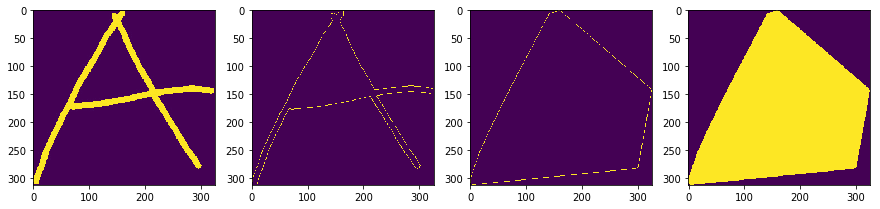

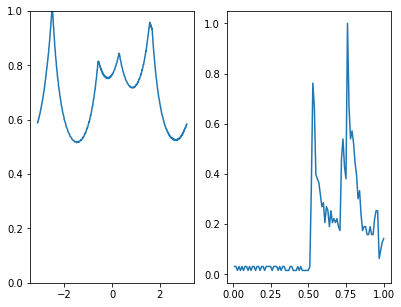

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


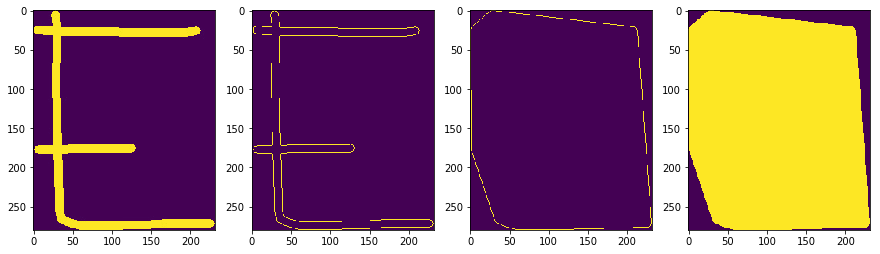

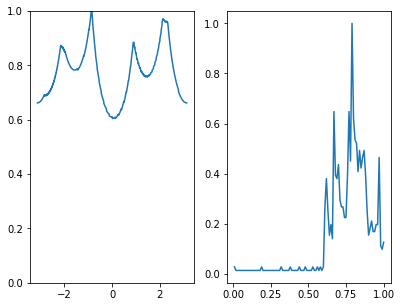

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


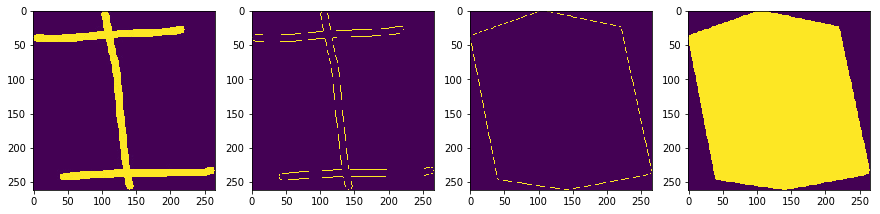

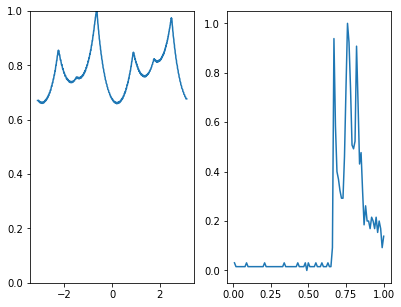

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


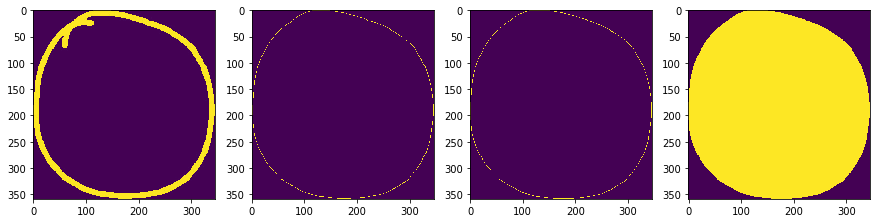

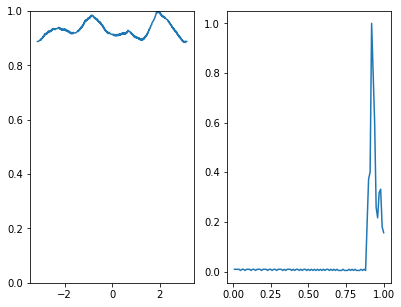

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


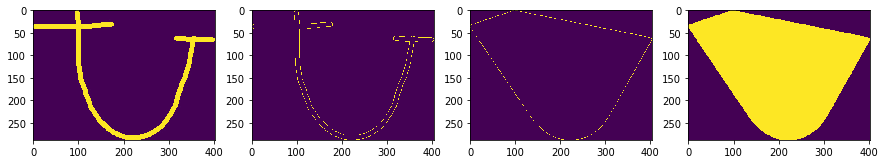

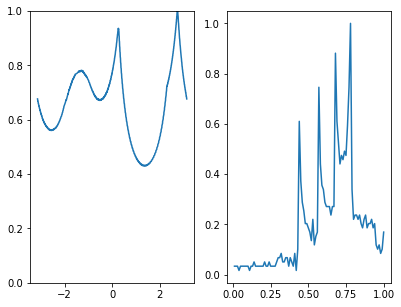

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


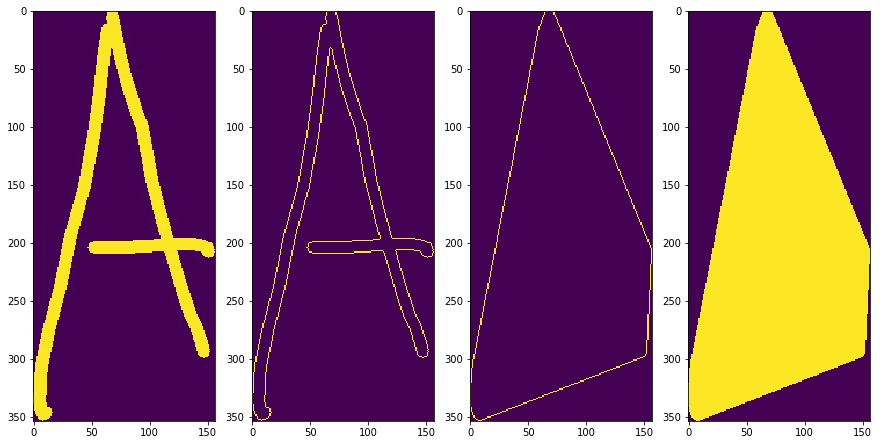

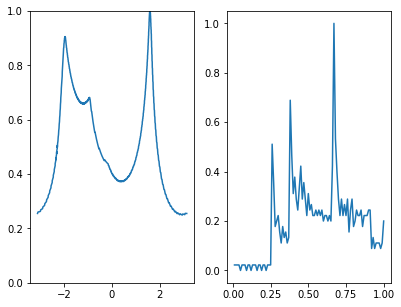

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
[[20.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 6.]]


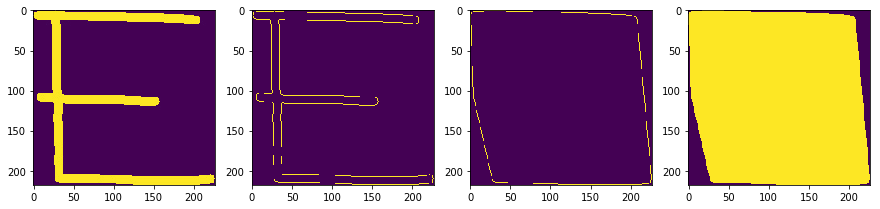

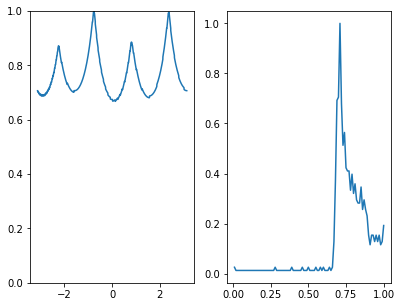

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
[[ 7.]
 [ 8.]
 [ 0.]
 [15.]
 [ 0.]]


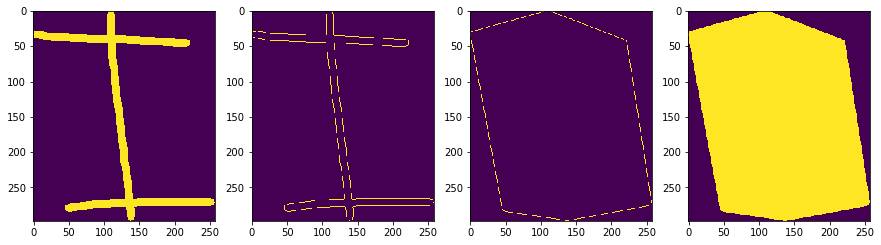

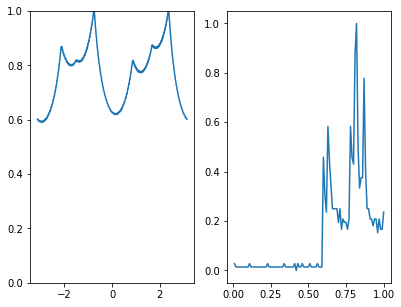

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
[[ 0.]
 [ 0.]
 [20.]
 [ 1.]
 [ 9.]]


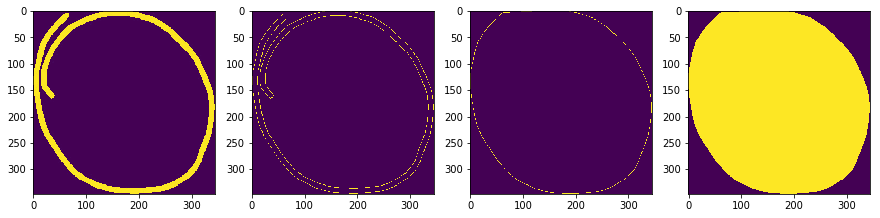

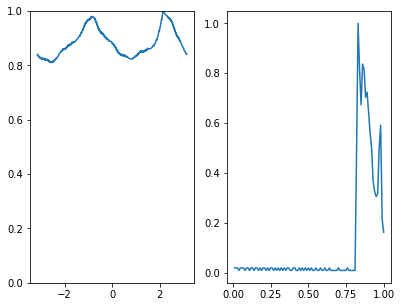

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
[[24.]
 [ 2.]
 [ 0.]
 [ 4.]
 [ 0.]]


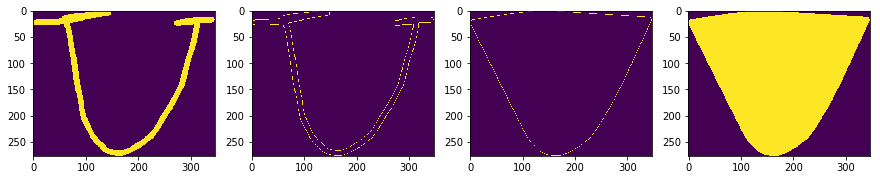

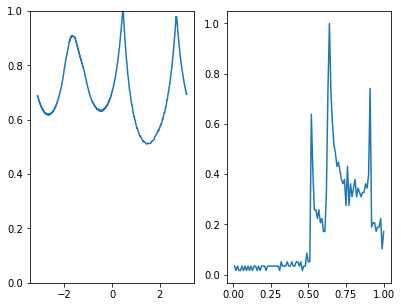

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
[[ 6.]
 [ 1.]
 [15.]
 [ 1.]
 [ 7.]]


In [8]:
retVar = 0.95
A = getPCAFeatures("A_mayuscula",1,26,retVar)
E = getPCAFeatures("E_mayuscula",1,26,retVar)
I = getPCAFeatures("I_mayuscula",1,26,retVar)
O = getPCAFeatures("O_mayuscula",1,26,retVar)
U = getPCAFeatures("U_mayuscula",1,26,retVar)

classA = np.full((25, 1), 1)
classE = np.full((25, 1), 2)
classI = np.full((25, 1), 3)
classO = np.full((25, 1), 4)
classU = np.full((25, 1), 5)
classData = np.concatenate((classA,classE,classI,classO,classU),axis=0)
trainData = np.concatenate((A,E,I,O,U),axis=0)
trainData = np.array(trainData, dtype=np.float32)
classData = np.array(classData, dtype=np.int32)

Clasificador_NB = cv2.ml.NormalBayesClassifier_create()
Clasificador_NB.train(trainData, cv2.ml.ROW_SAMPLE, classData)

X = getPCAFeatures("A_mayuscula",1,31,retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

_, retval, resultados = Clasificador_NB.predictProb(X)

for i in range(len(resultados)):
    resultados[i,:] = resultados[i,:]/max(resultados[i,:])

cont = np.full((5, 1), 0)

for i in range(len(resultados)):
    for j in range(len(resultados[0])):
        if(resultados[i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)


X = getPCAFeatures("E_mayuscula",1,31,retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

_, retval, resultados = Clasificador_NB.predictProb(X)

for i in range(len(resultados)):
    resultados[i,:] = resultados[i,:]/max(resultados[i,:])

cont = np.full((5, 1), 0)

for i in range(len(resultados)):
    for j in range(len(resultados[0])):
        if(resultados[i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)


X = getPCAFeatures("I_mayuscula",1,31,retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

_, retval, resultados = Clasificador_NB.predictProb(X)

for i in range(len(resultados)):
    resultados[i,:] = resultados[i,:]/max(resultados[i,:])

cont = np.full((5, 1), 0)

for i in range(len(resultados)):
    for j in range(len(resultados[0])):
        if(resultados[i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)


X = getPCAFeatures("O_mayuscula",1,31,retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

_, retval, resultados = Clasificador_NB.predictProb(X)

for i in range(len(resultados)):
    resultados[i,:] = resultados[i,:]/max(resultados[i,:])

cont = np.full((5, 1), 0)

for i in range(len(resultados)):
    for j in range(len(resultados[0])):
        if(resultados[i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)


X = getPCAFeatures("U_mayuscula",1,31,retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

_, retval, resultados = Clasificador_NB.predictProb(X)

for i in range(len(resultados)):
    resultados[i,:] = resultados[i,:]/max(resultados[i,:])

cont = np.full((5, 1), 0)

for i in range(len(resultados)):
    for j in range(len(resultados[0])):
        if(resultados[i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

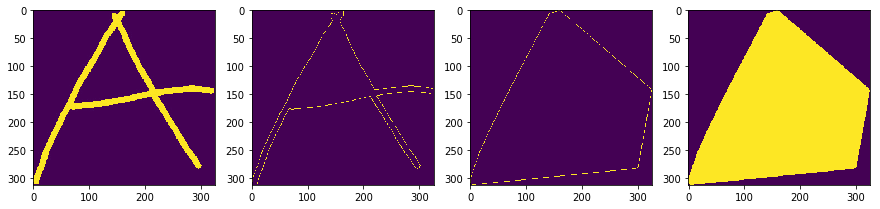

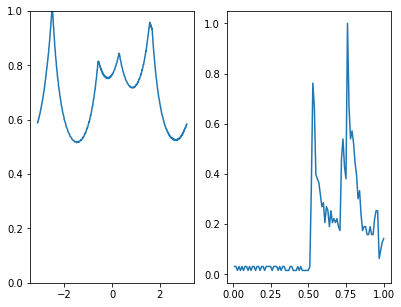

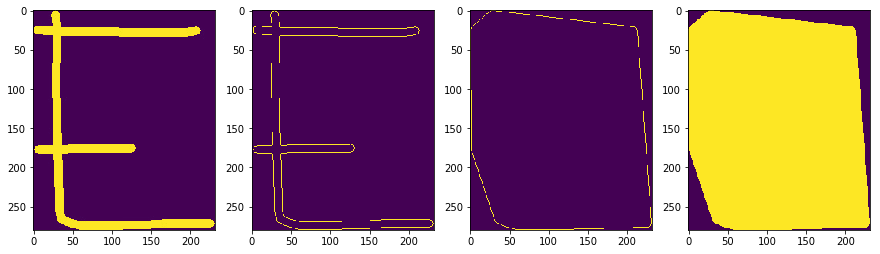

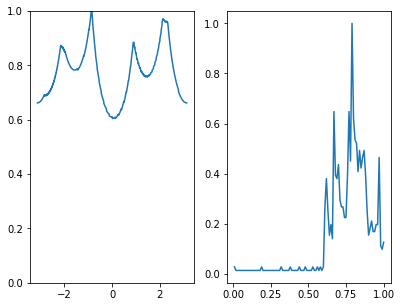

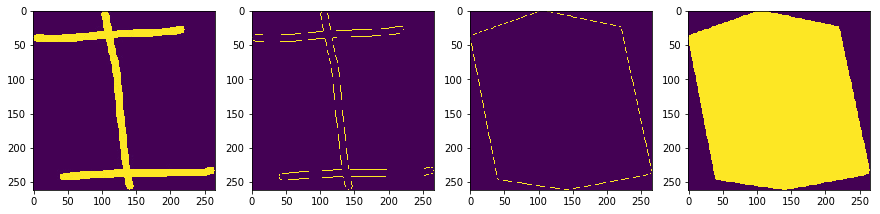

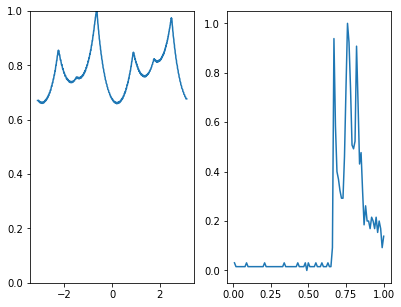

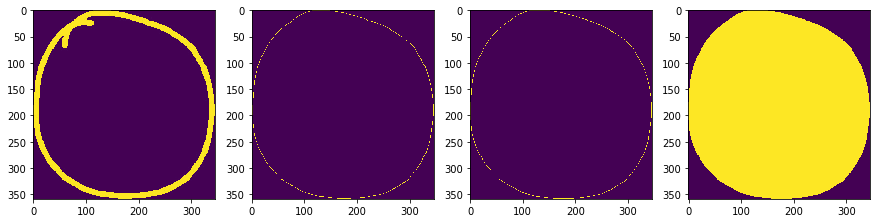

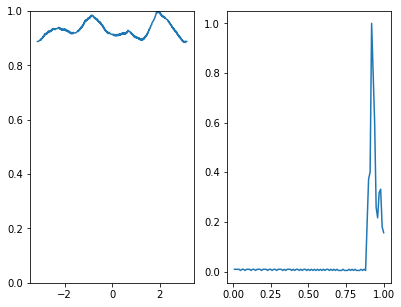

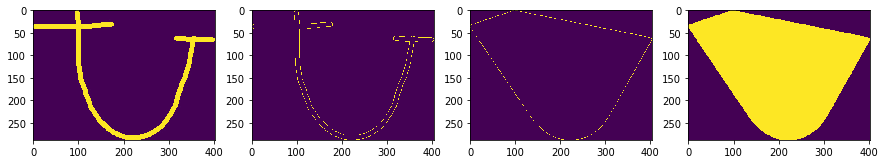

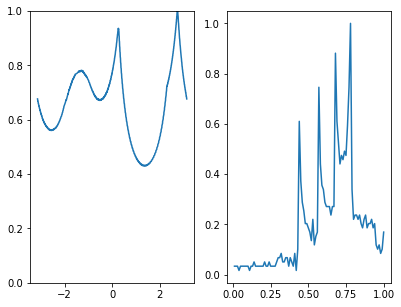

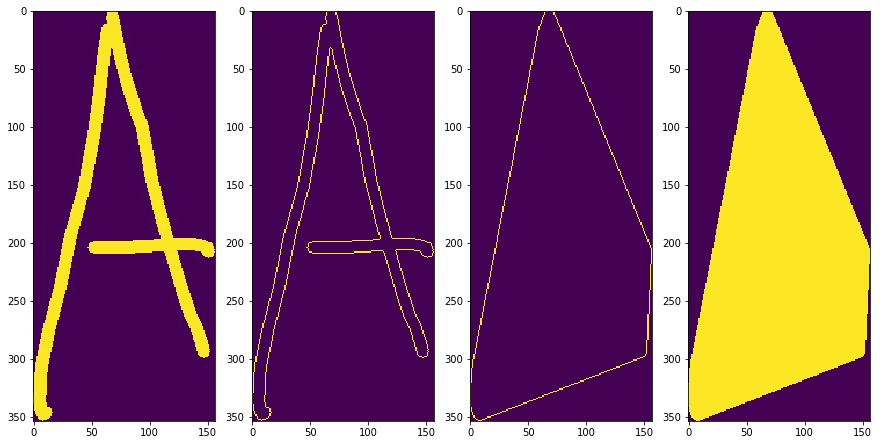

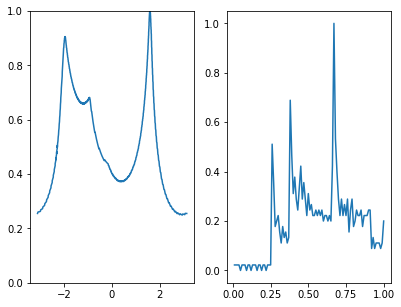

30
5
[[30.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


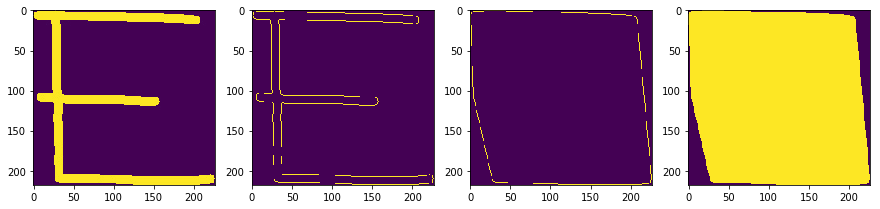

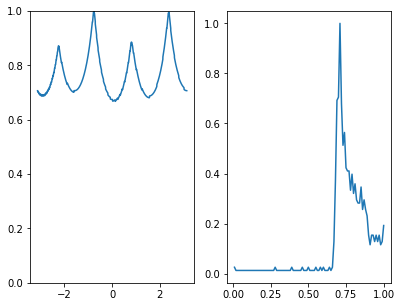

30
5
[[ 0.]
 [29.]
 [ 0.]
 [ 1.]
 [ 0.]]


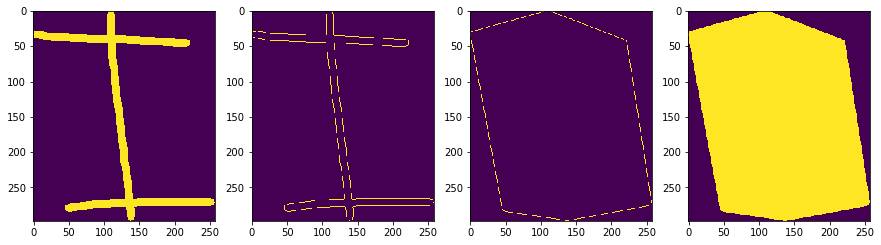

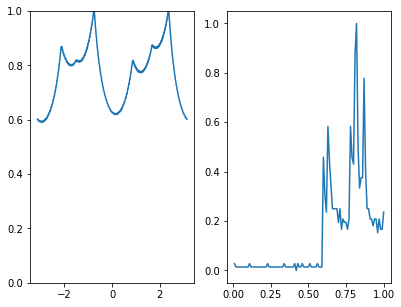

30
5
[[ 0.]
 [ 1.]
 [29.]
 [ 0.]
 [ 0.]]


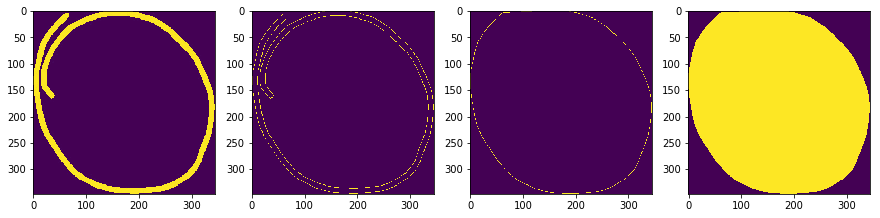

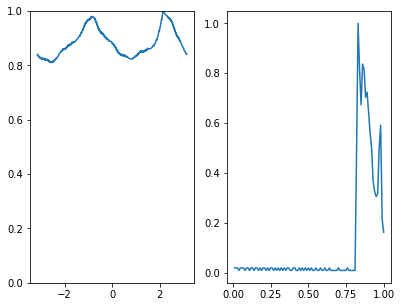

30
5
[[ 0.]
 [ 0.]
 [ 0.]
 [30.]
 [ 0.]]


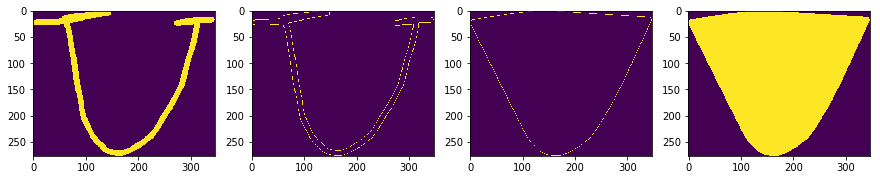

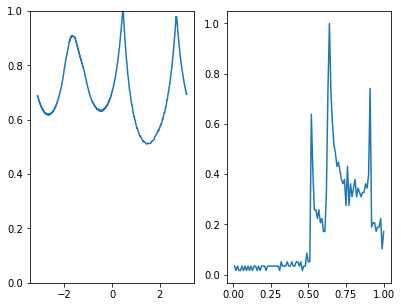

30
5
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [30.]]


In [9]:
# ANN MLP con vector de caracteristicas
ARN = cv2.ml.ANN_MLP_create()
ARN.setLayerSizes(np.array([77, 5, 5], dtype=np.uint8))
ARN.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM,0,0)
ARN.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)

retVar = 0.95
A = getFeatures("A_mayuscula",1,26)
E = getFeatures("E_mayuscula",1,26)
I = getFeatures("I_mayuscula",1,26)
O = getFeatures("O_mayuscula",1,26)
U = getFeatures("U_mayuscula",1,26)

classData = np.array([[1, 0, 0, 0, 0]])
classA = np.array([[1, 0, 0, 0, 0]])
classE = np.array([[0, 1, 0, 0, 0]])
classI = np.array([[0, 0, 1, 0, 0]])
classO = np.array([[0, 0, 0, 1, 0]])
classU = np.array([[0, 0, 0, 0, 1]])
for i in range(24):
    classData = np.concatenate((classData,classA), axis=0)
for i in range(25):
    classData = np.concatenate((classData,classE), axis=0)  
for i in range(25):
    classData = np.concatenate((classData,classI), axis=0)  
for i in range(25):
    classData = np.concatenate((classData,classO), axis=0)
for i in range(25):
    classData = np.concatenate((classData,classU), axis=0)  
    
#print(classData)

trainData = np.concatenate((A,E,I,O,U),axis=0)
trainData = np.array(trainData, dtype=np.float32)
classData = np.array(classData, dtype=np.float32)

ARN.train(trainData, cv2.ml.ROW_SAMPLE, classData)

X = getFeatures("A_mayuscula",1,31)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getFeatures("E_mayuscula",1,31)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getFeatures("I_mayuscula",1,31)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getFeatures("O_mayuscula",1,31)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getFeatures("U_mayuscula",1,31)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)


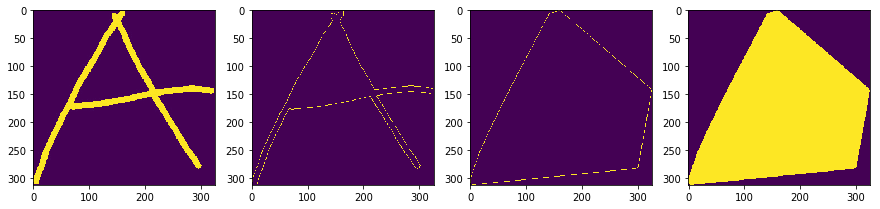

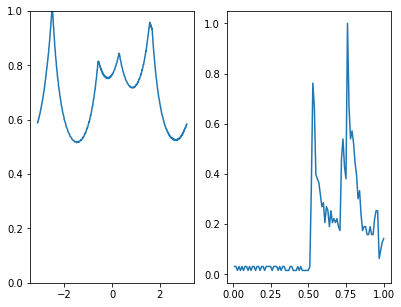

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


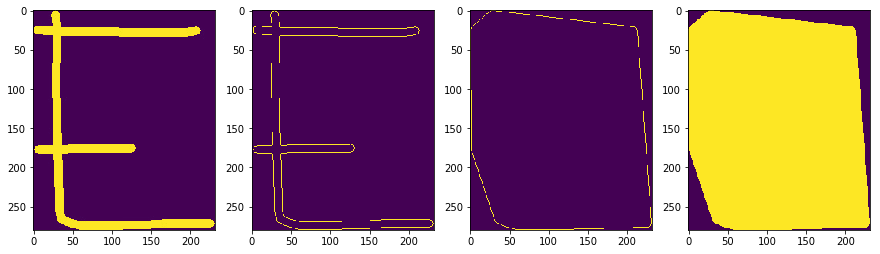

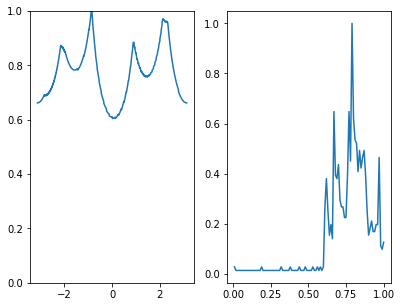

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


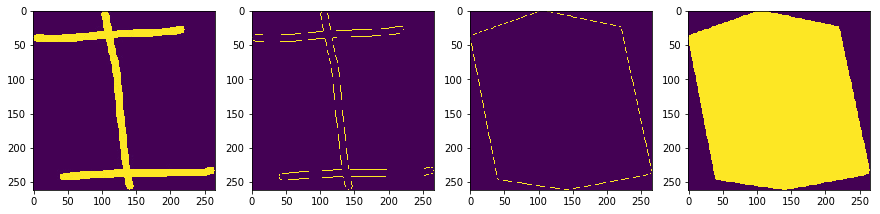

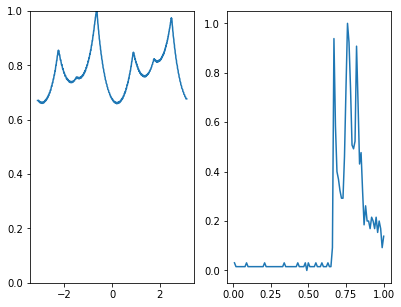

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


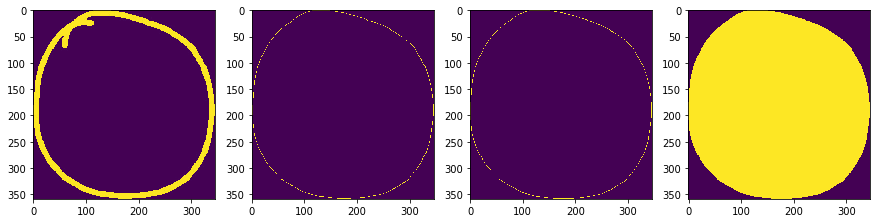

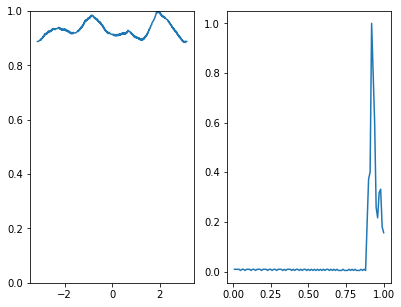

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


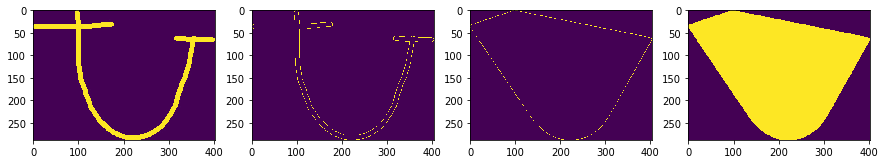

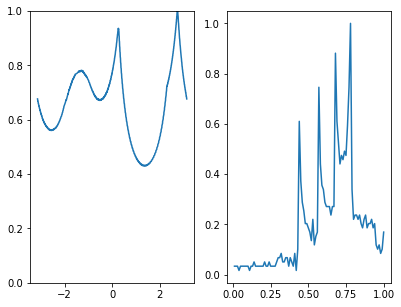

Vector Mean
1
77
Vector Caracteristicas
25
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
25
2


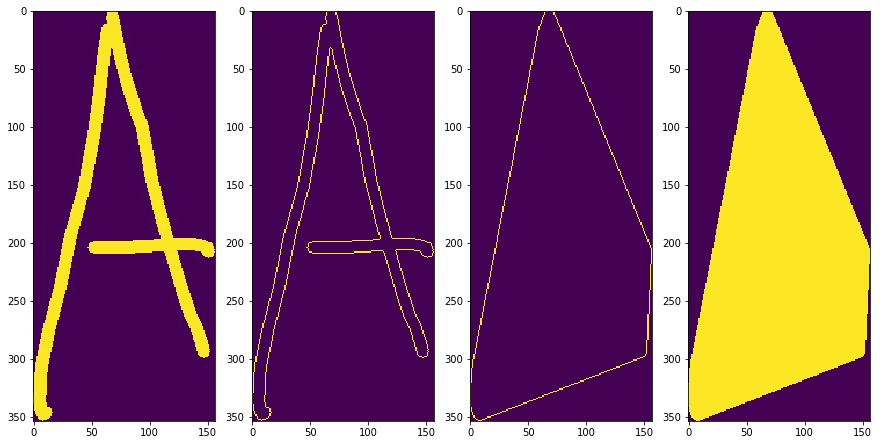

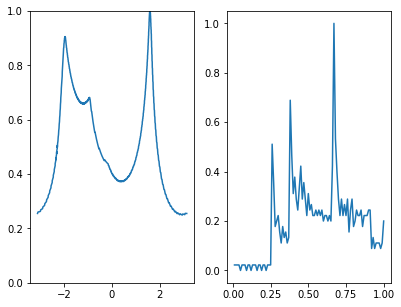

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
5
[[ 0.]
 [ 0.]
 [ 1.]
 [29.]
 [ 0.]]


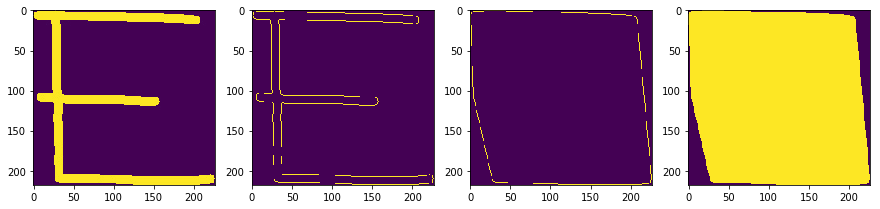

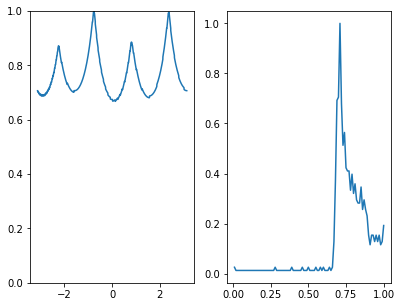

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
5
[[ 0.]
 [26.]
 [ 0.]
 [ 4.]
 [ 0.]]


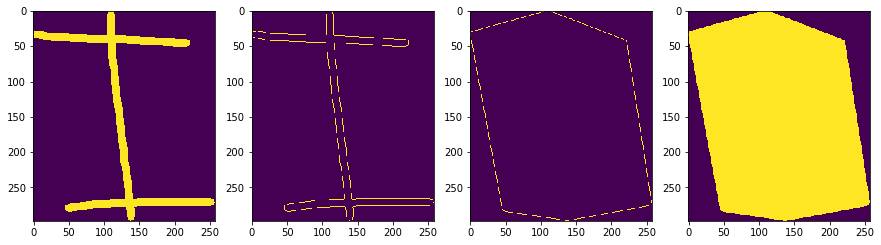

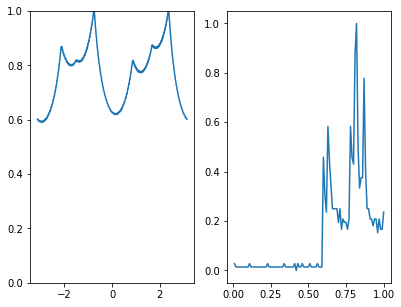

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
5
[[ 0.]
 [ 0.]
 [30.]
 [ 0.]
 [ 0.]]


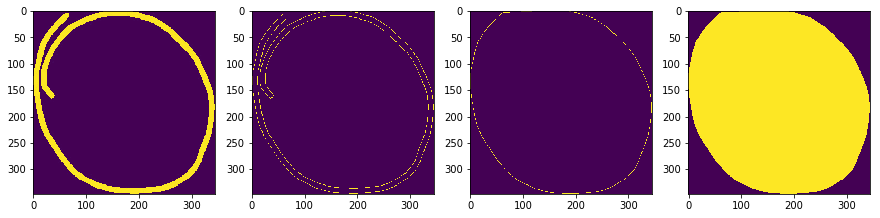

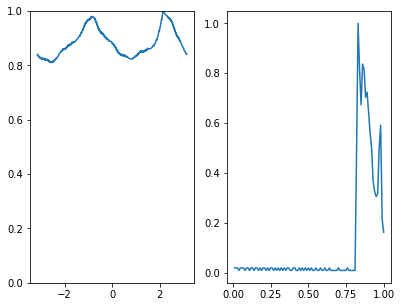

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
5
[[ 0.]
 [ 0.]
 [ 0.]
 [30.]
 [ 0.]]


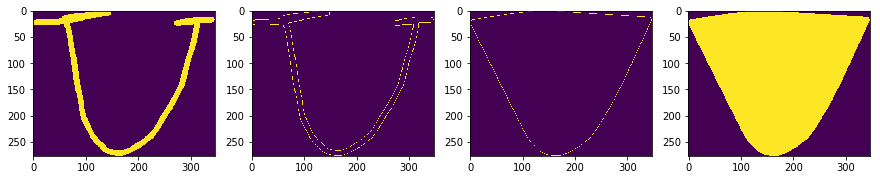

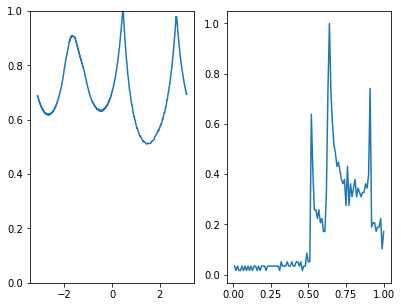

Vector Mean
1
77
Vector Caracteristicas
30
77
EigenVector 95.0%
2
77
Vector de Caracteristicas PCA 95.0%
30
2
30
5
[[ 0.]
 [ 0.]
 [18.]
 [12.]
 [ 0.]]


In [10]:
# ANN MLP con vector de caracteristicas despues de PCA
ARN = cv2.ml.ANN_MLP_create()
ARN.setLayerSizes(np.array([2, 5, 5], dtype=np.uint8))
ARN.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM,0,0)
ARN.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)

retVar = 0.95
A = getPCAFeatures("A_mayuscula",1,26, retVar)
E = getPCAFeatures("E_mayuscula",1,26, retVar)
I = getPCAFeatures("I_mayuscula",1,26, retVar)
O = getPCAFeatures("O_mayuscula",1,26, retVar)
U = getPCAFeatures("U_mayuscula",1,26, retVar)

classData = np.array([[1, 0, 0, 0, 0]])
classA = np.array([[1, 0, 0, 0, 0]])
classE = np.array([[0, 1, 0, 0, 0]])
classI = np.array([[0, 0, 1, 0, 0]])
classO = np.array([[0, 0, 0, 1, 0]])
classU = np.array([[0, 0, 0, 0, 1]])
for i in range(24):
    classData = np.concatenate((classData,classA), axis=0)
for i in range(25):
    classData = np.concatenate((classData,classE), axis=0)  
for i in range(25):
    classData = np.concatenate((classData,classI), axis=0)  
for i in range(25):
    classData = np.concatenate((classData,classO), axis=0)
for i in range(25):
    classData = np.concatenate((classData,classU), axis=0)  
    
#print(classData)

trainData = np.concatenate((A,E,I,O,U),axis=0)
trainData = np.array(trainData, dtype=np.float32)
classData = np.array(classData, dtype=np.float32)

ARN.train(trainData, cv2.ml.ROW_SAMPLE, classData)

X = getPCAFeatures("A_mayuscula",1,31, retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getPCAFeatures("E_mayuscula",1,31, retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getPCAFeatures("I_mayuscula",1,31, retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getPCAFeatures("O_mayuscula",1,31, retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)

X = getPCAFeatures("U_mayuscula",1,31, retVar)
X = np.array(X, dtype=np.float32)
print(len(X))

resultados = ARN.predict(X)



for i in range(len(resultados[1])):
    resultados[1][i,:] = resultados[1][i,:]/max(resultados[1][i,:])

print(len(resultados[1][0]))    
    
cont = np.full((5, 1), 0)

for i in range(len(resultados[1])):
    for j in range(len(resultados[1][i])):
        if(resultados[1][i,j]==1.0):
            cont[j] += 1
            
cont = np.array(cont, dtype=np.float32)
print(cont)
